In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat as loadmat
% matplotlib inline

# 7.1 Natural Gradient (3 points)


(a) Extend your code from the previous problem sheet to get an ICA-learning scheme based on the natural gradient with a learning rate η that decays slowly to 0 (e.g. ηt+1 = ληt with λ ≈ 1, λ < 1). Note that depending on λ you have to iterate over the (shuffled) data more than once for proper convergence.



In [15]:
def fhat(y):
    return 1 / (1 + np.exp(-y))

def fhatpp_fhatp(y):
    return 1 - 2*fhat(y)

def dWnatural(eta, W, x):
    #x0 x1
    #x0 x1
    #xv = np.vstack( (x.T, x.T) )
    xv = np.vstack( (x.T, x.T, x.T) )
    #x0 x0
    #x1 x1
    #xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    subtotal = (np.eye(W.shape[0]) + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))
    #return eta * np.dot(subtotal, np.dot(W.T, W))
    return eta * np.dot(subtotal, W)

def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p



def gradientdescent(A, W, s, eta, l):

    print("Mixing Matrix:\n"+str(A)+"\nDet: "+str(np.linalg.det(A)))
    x = np.dot(A, s)

    #(c) Remove the temporal structure by permuting the columns of the N × p matrix X randomly.
    xs = np.random.permutation(x)

    #(e) Center the data to zero mean.
    #print( np.mean(x, axis=1).shape )
    x_mean = np.mean(xs, axis=1).reshape(-1,1)
    xsc = xs - x_mean

    #(f) Initialize the unmixing matrix W with random values.
    #s = W.x, s: Nxp, x: Nxp -> W: NxN
    #W = np.random.uniform(0, 1, (N, N))

    #(c) Choose a suitable learning rate η and apply both versions to the data to unmix the sources.
    epsilon = .000000001
    Wb = W.copy()
    Wbbs = W.copy()
    BConverged = False
    BbsConverged = False
    etan = eta
    
    print("Initial W:\n"+str(W))
    for n in range(10):
        for t in range(0, xsc.shape[1]):
            xa = xsc[:,t]
            #xa = xsc[:,np.random.randint(xsc.shape[1])]
            etan = etan*l
        
            #Natural
            if not BConverged:
                natural = dWnatural(etan, Wb, xa)
                if np.absolute(natural).sum() > epsilon:
                    Wb = Wb + natural
                else:
                    BConverged = True
                    print("(b) converged at: "+str(n*t))
            
            #Natural with Bell-Sejnowski regularization
            if not BbsConverged:
                naturalbs = dWnatural(etan, Wbbs, xa)
                for n in range(N):
                    naturalbs[n, n] = 0
                if np.absolute(naturalbs).sum() > epsilon:
                    Wbbs = Wbbs + naturalbs
                    for n in range(N):
                        Wbbs[n, n] = 1
                else:
                    BbsConverged = True
                    print("(b.bs) Bell-Sejnowski converged at: "+str(n*t))
            else:
                pass
    return Wb, Wbbs, x, x_mean

def myplot(Wb, Wbbs, x, x_mean, s):    
    #retrieve shats - ^s
    shatb = np.dot(Wb, x)
    shatb_decentered = shatb + x_mean
    shatbbs = np.dot(Wbbs, x)
    shatbbs_decentered = shatbbs + x_mean
    
    #Check correlations, to check whcih source goes to which output channel
    mixcors = buildcorrelations(N, s, x)
    naturalcors = buildcorrelations(N, shatb_decentered, s)
    naturalbscors = buildcorrelations(N, shatbbs_decentered, s)
    
    isflippedmixes = (mixcors[0,0] < mixcors[0,1]) and (mixcors[1,0] > mixcors[1,1])
    isflippednatural = (naturalcors[0,0] < naturalcors[0,1]) and (naturalcors[1,0] > naturalcors[1,1])
    isflippednaturalbs = (naturalbscors[0,0] < naturalbscors[0,1]) and (naturalbscors[1,0] > naturalbscors[1,1])

    ys = [(s, 'Original Sources', False), 
          (x, 'Mixed Sources', isflippedmixes), 
          (shatb_decentered, '(b) - Natural Gradient Descent', isflippednatural), 
          (shatbbs_decentered, '(b) - Natural Gradient Descent Bell-Sejnowski', isflippednaturalbs)]
    ylimits = [-14,14]
    f, axarr = plt.subplots(len(ys), 3)
    f.set_size_inches(30, len(ys)*10, forward=False) 
    
    axarr[0, 0].set_title("Source 1")
    axarr[0, 1].set_title("Source 2")
    axarr[0, 2].set_title("Source 3")
    
    for r in range(len(ys)):
        #axarr[r, 0].set_ylim(ylimits)
        #axarr[r, 1].set_ylim(ylimits)
        #axarr[r, 2].set_ylim(ylimits)
        axarr[r, 0].set_ylabel(ys[r][1])
    
        axarr[r, 0].plot(range(ys[r][0].shape[1]), ys[r][0][0])
        axarr[r, 1].plot(range(ys[r][0].shape[1]), ys[r][0][1])
        axarr[r, 2].plot(range(ys[r][0].shape[1]), ys[r][0][2])
        axarr[r, 0].set_title("Output 1")
        axarr[r, 1].set_title("Output 2")
        axarr[r, 2].set_title("Output 3")
            
    plt.show()



(b) Use the two sound signals from the last problem sheet and add (as third source s3) an additional “noise” source (normally distributed random numbers with a standard deviation similar to the two signals). Mix the signals using a mixing matrix of your choice and apply your ICA-algorithm. Plot the Mixed Sounds and recovered Sources



Standard Deviation s1: 0.998545937615
Standard Deviation s2: 0.998854345166
Standard Deviation s3: 0.986100852986
Mixing Matrix:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Det: 1.0
Initial W:
[[ 0.94736096  0.06200152  0.09854062]
 [ 0.04283364  0.86946837  0.00626526]
 [ 0.05738817  0.05842622  0.99659339]]
(b.bs) Bell-Sejnowski converged at: 12422
(b) converged at: 35552
Wb:
[[ 0.94790721  0.06201358  0.09855416]
 [ 0.04284101  0.87002072  0.00626386]
 [ 0.05739633  0.05844015  0.99721645]]
Wbbs:
[[ 1.          0.06200926  0.0985515 ]
 [ 0.04283859  1.          0.00626381]
 [ 0.05739381  0.05843595  1.        ]]


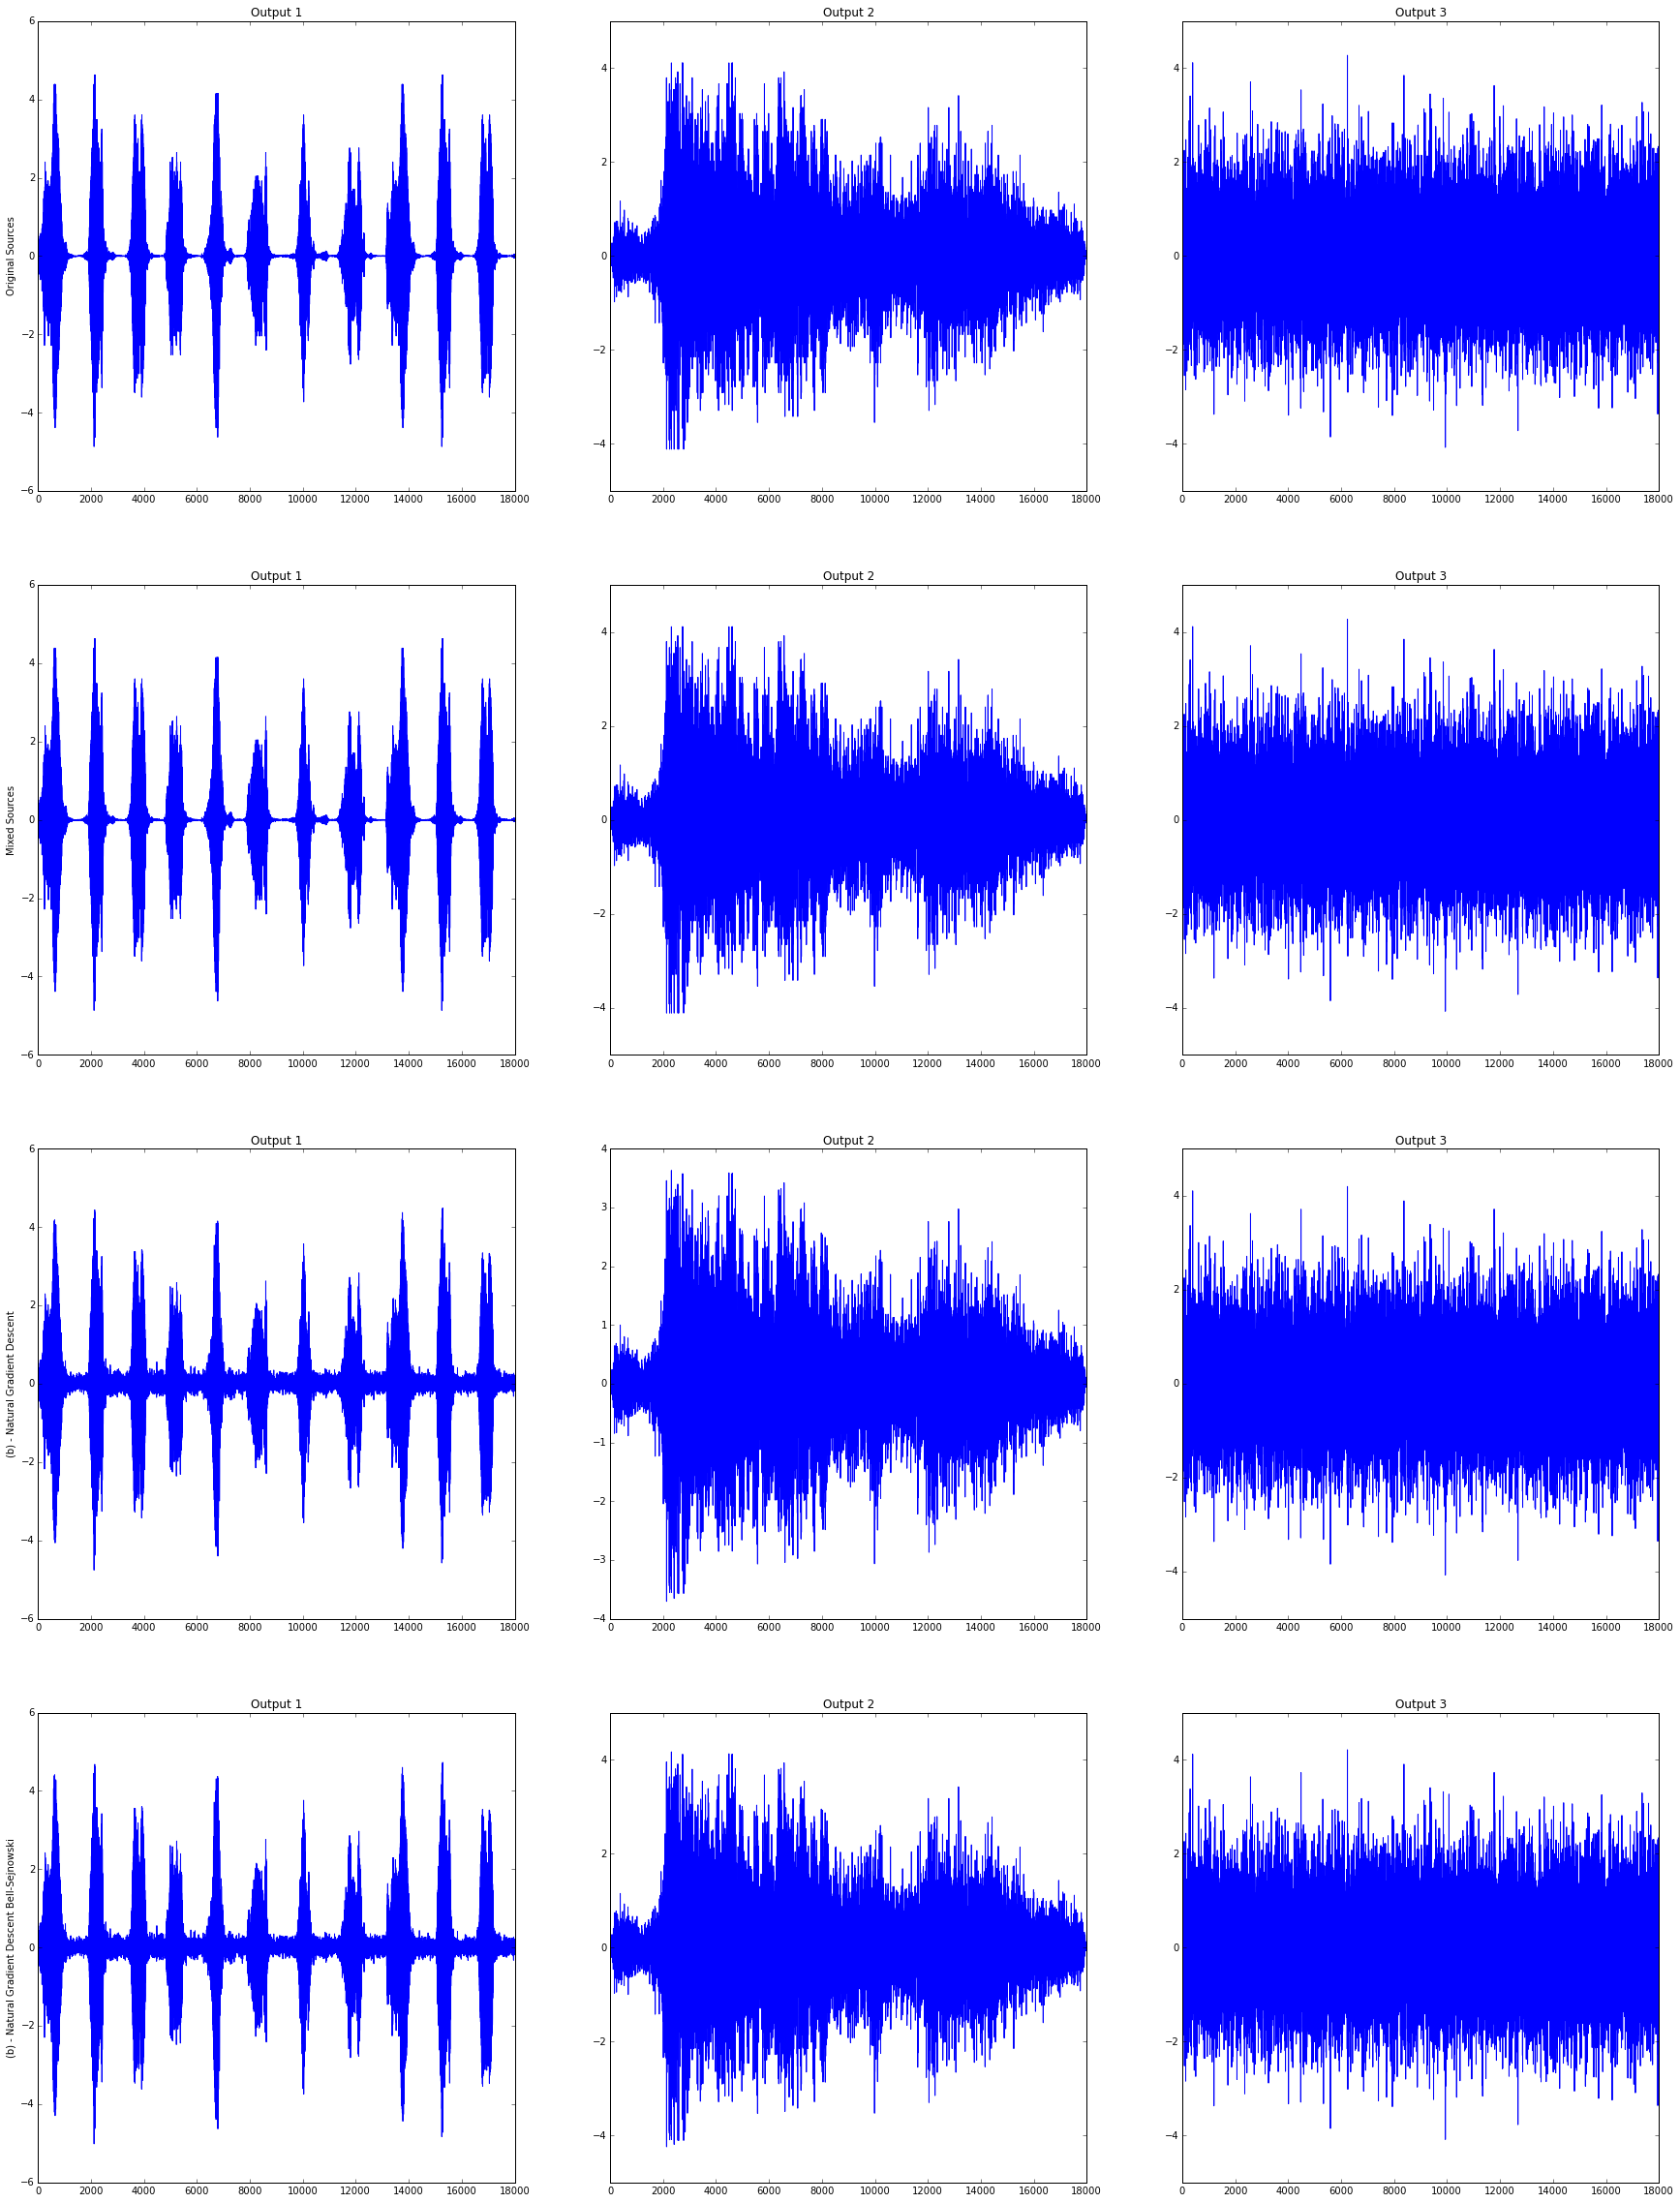

In [68]:
s1 = np.loadtxt("sounds/sound1.dat")
s2 = np.loadtxt("sounds/sound2.dat")
s3 = np.random.normal(0, 1, len(s1))
s = np.array([s1, s2, s3])
print("Standard Deviation s1: "+str(np.std(s[0])))
print("Standard Deviation s2: "+str(np.std(s[1])))
print("Standard Deviation s3: "+str(np.std(s[2])))
N = s.shape[0]

A = np.eye(N)
W = np.random.uniform(0, .1, (N, N))
W[0,0] = np.random.uniform(.8, 1)
W[1,1] = np.random.uniform(.8, 1)
W[2,2] = np.random.uniform(.8, 1)

Wb, Wbbs, x, x_mean = gradientdescent(A, W, s, .0000001, .9999)
print("Wb:")
print(Wb)
print("Wbbs:")
print(Wbbs)
myplot(Wb, Wbbs, x, x_mean, s)


(c) Do the same analysis but adding a different “noise”-source (e.g. Laplace distributed) instead of the normal one.

Standard Deviation s1: 0.998545937615
Standard Deviation s2: 0.998854345166
Standard Deviation s3: 0.980715089168
Mixing Matrix:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Det: 1.0
Initial W:
[[ 0.92268291  0.06539629  0.02809297]
 [ 0.02891274  0.81202717  0.01726697]
 [ 0.07903204  0.09890617  0.91645418]]
(b.bs) Bell-Sejnowski converged at: 17768
(b) converged at: 32670
Wb:
[[ 0.92328144  0.06540724  0.02809883]
 [ 0.028915    0.81256614  0.01726954]
 [ 0.0790489   0.09892605  0.91699215]]
Wbbs:
[[ 1.          0.06539828  0.02809692]
 [ 0.02891187  1.          0.01726796]
 [ 0.07904427  0.09891487  1.        ]]


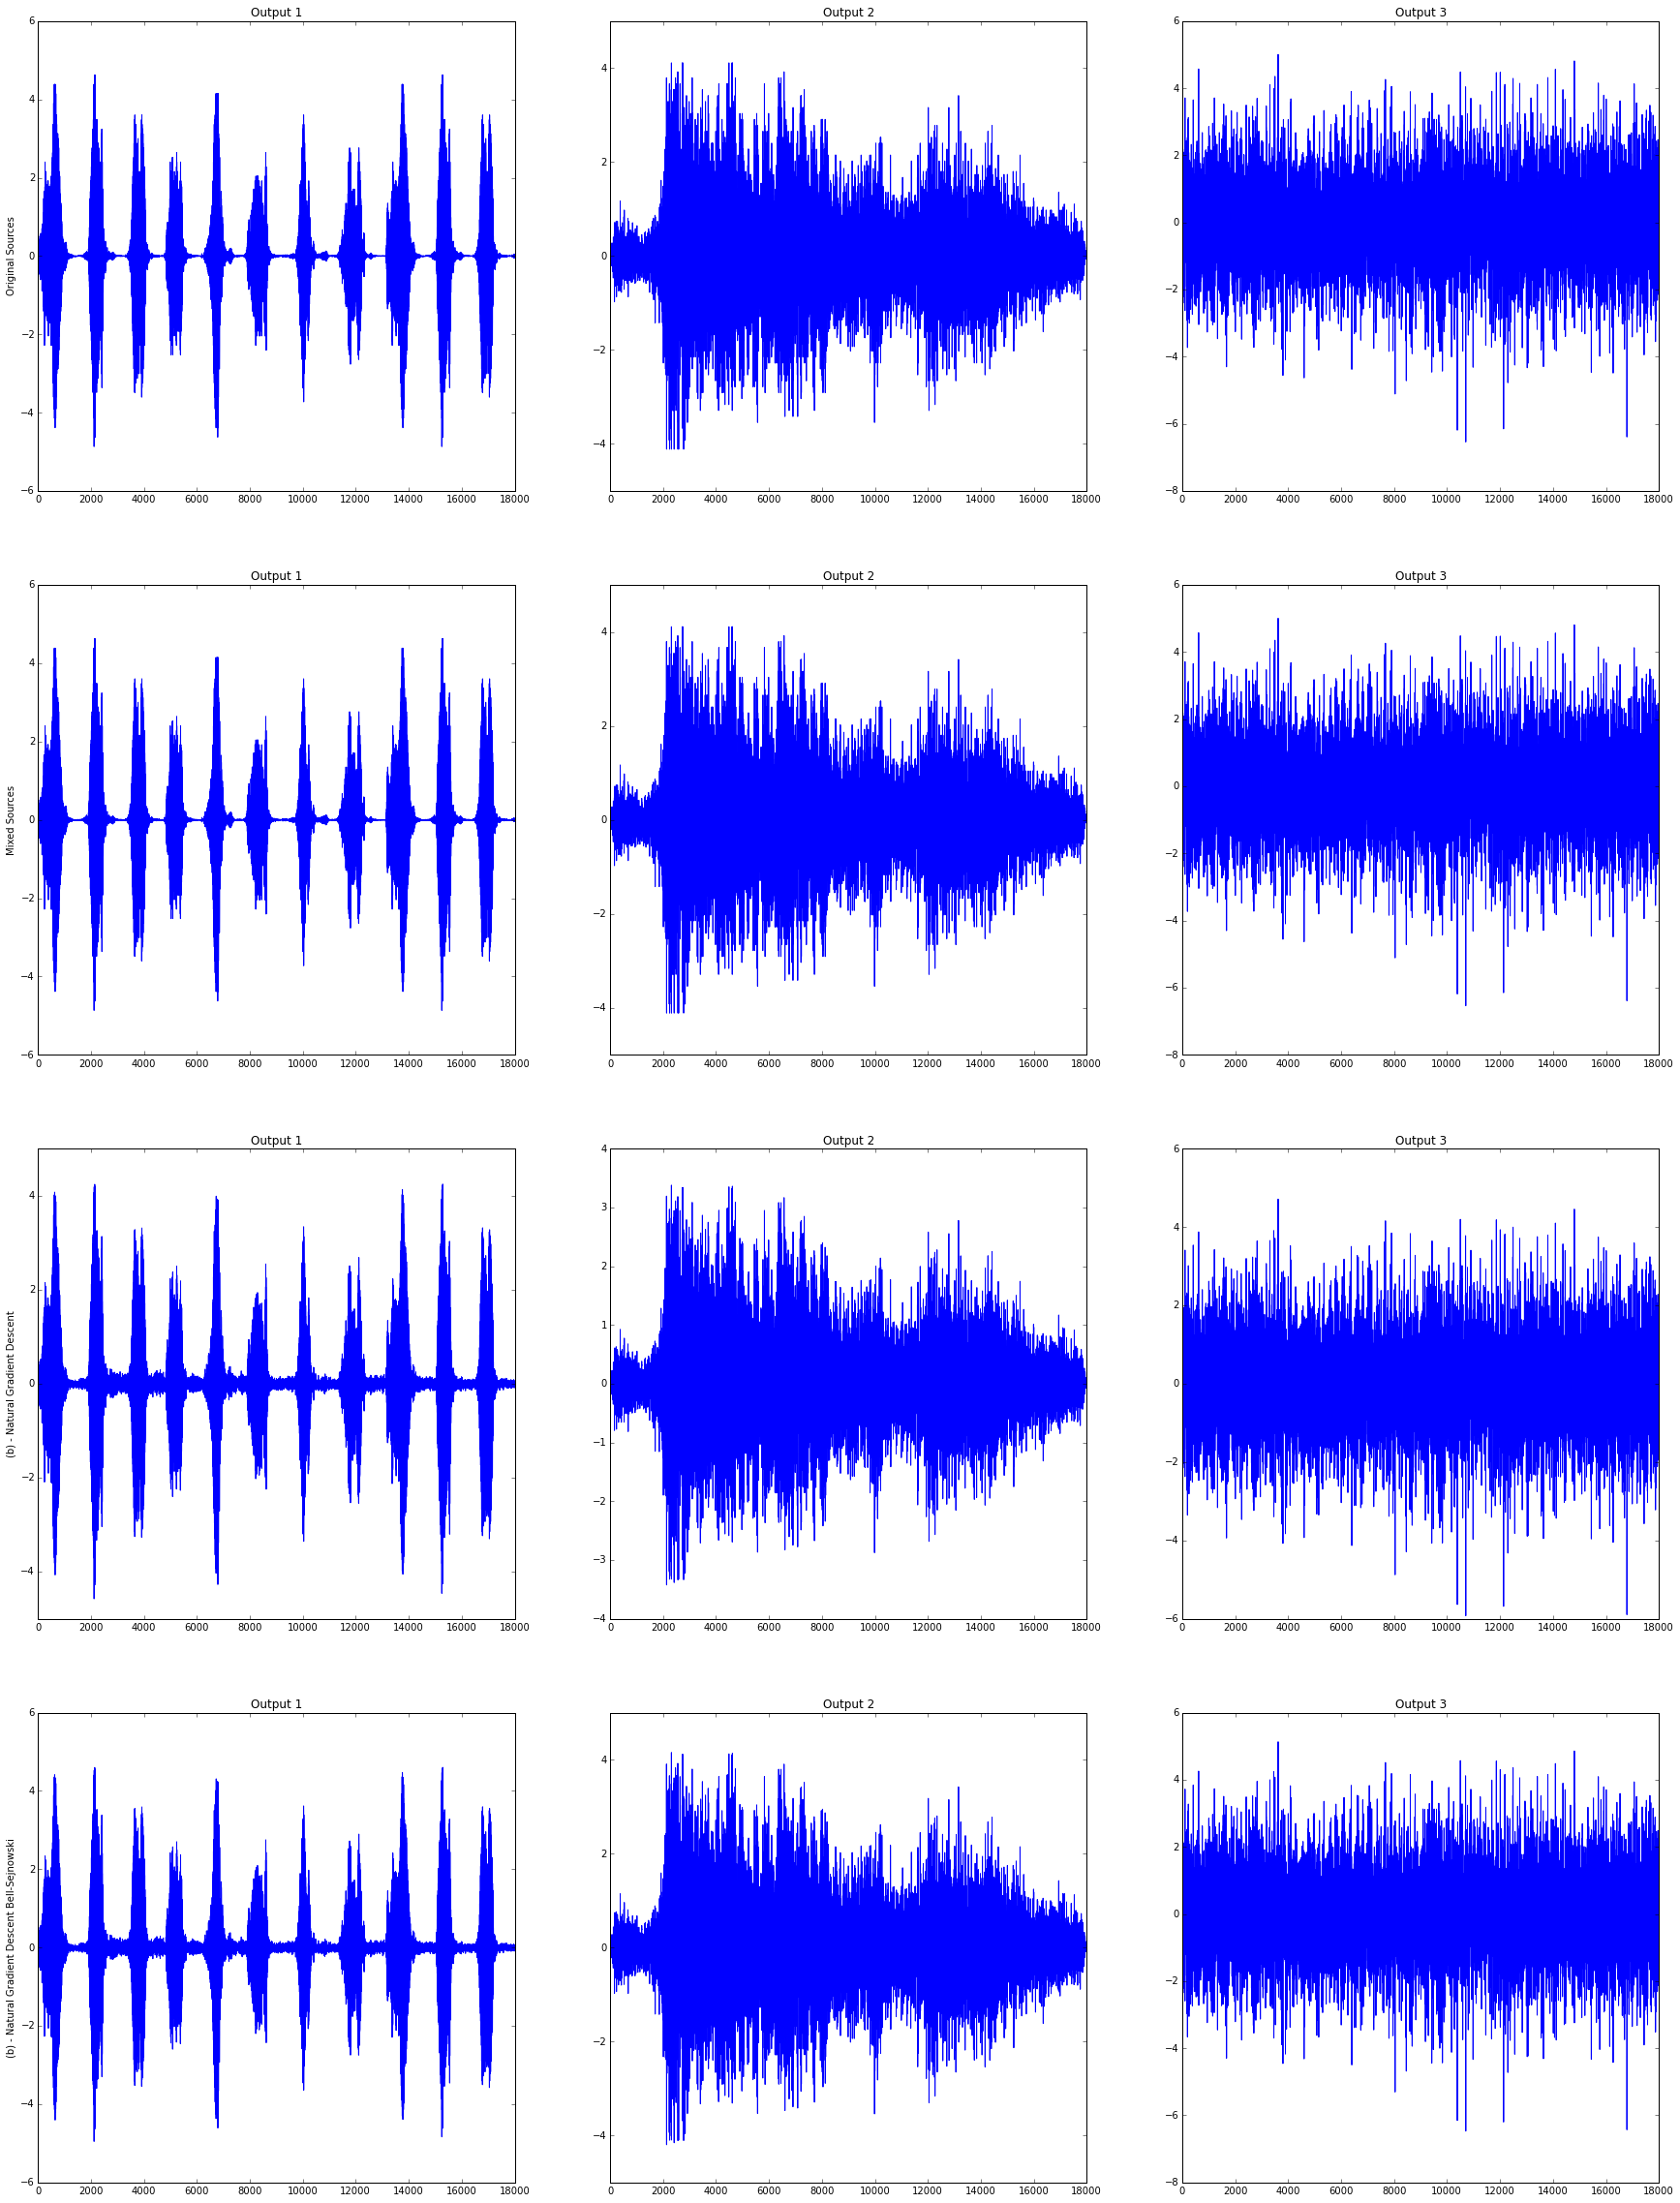

In [69]:
s1 = np.loadtxt("sounds/sound1.dat")
s2 = np.loadtxt("sounds/sound2.dat")
s3 = np.random.laplace(0.0, 0.7, len(s1))
s = np.array([s1, s2, s3])


print("Standard Deviation s1: "+str(np.std(s[0])))
print("Standard Deviation s2: "+str(np.std(s[1])))
print("Standard Deviation s3: "+str(np.std(s[2])))
N = s.shape[0]
A = np.eye(N)
W = np.random.uniform(0, .1, (N, N))
W[0,0] = np.random.uniform(.8, 1)
W[1,1] = np.random.uniform(.8, 1)
W[2,2] = np.random.uniform(.8, 1)


Wb, Wbbs, x, x_mean = gradientdescent(A, W, s, .0000001, .9999)
print("Wb:")
print(Wb)
print("Wbbs:")
print(Wbbs)
myplot(Wb, Wbbs, x, x_mean, s)



# Assignment 7.3

The file distrib.mat contains three toy datasets (uniform, normal, laplacian), each 10000 samples of 2 sources. Do the following for each dataset (which can be read for example using Python with loadmat from scipy.io):


In [19]:
laplacian = loadmat("distrib.mat")["laplacian"]
normal = loadmat("distrib.mat")["normal"]
uniform = loadmat("distrib.mat")["uniform"]

(a) Apply the following mixing matrix A to the original data s:
```
    4 3
    2 1
```



In [20]:
A = np.array([[4,3],[2,1]])
xl = np.dot(A, laplacian)
xn = np.dot(A, normal)
xu = np.dot(A, uniform)

(b) Center the mixed data to zero mean.


In [21]:
#keep as pxd
xlc = (xl - np.mean(xl, axis=1).reshape(-1,1)).T
xnc = (xn - np.mean(xn, axis=1).reshape(-1,1)).T
xuc = (xu - np.mean(xu, axis=1).reshape(-1,1)).T


(c) Decorrelate the data by applying principal component analysis (PCA) and project them onto the principal components (PCs).


In [46]:
#Scatter the centered data, dxd
Sl = np.dot(xlc.T, xlc)
Sn = np.dot(xnc.T, xnc)
Su = np.dot(xuc.T, xuc)

#SOlve the eigensystem
Dl, Ul = np.linalg.eigh(Sl)
Dn, Un = np.linalg.eigh(Sn)
Du, Uu = np.linalg.eigh(Su)

#reverse the orders
Dl = Dl[::-1]
Dn = Dn[::-1]
Du = Du[::-1]
Ul = Ul.T[::-1]
Un = Un.T[::-1]
Uu = Uu.T[::-1]

#Projections
xlp = (np.dot(Ul, xlc.T)).T
xnp = (np.dot(Un, xnc.T)).T
xup = (np.dot(Uu, xuc.T)).T

(d) Scale the data to unit variance in each PC direction (now the data is whitened or sphered).


In [47]:
#scale to unit variance
xlpuv = xlp / np.std(xlp, axis=0)
xnpuv = xnp / np.std(xnp, axis=0)
xupuv = xup / np.std(xup, axis=0)


(e) Rotate the data by different angles θ
and calculate the kurtosis1 empirically for each dimension:
```
      xθ = | cos(θ)   −sin(θ) | x
           | sin(θ)   cos(θ)  |
      θ = 0,π,...,2π
```



In [62]:
#compute all rotation amounts
thetas = [(np.pi*x)/50 for x in range(0, 100)]
#compute rotation matrices
rs = [np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]) for theta in thetas]
#compute kurtosises
kurtls = np.array([np.mean(np.power(np.dot(r, xlpuv.T),4), axis=1)-3 for r in rs])
kurtns = np.array([np.mean(np.power(np.dot(r, xnpuv.T),4), axis=1)-3 for r in rs])
kurtus = np.array([np.mean(np.power(np.dot(r, xupuv.T),4), axis=1)-3 for r in rs])


(100, 2)


(f) Find the minimum and maximum kurtosis value for the first dimension and rotate the data accordingly.

In [63]:
kurtlminidx = np.argmin(kurtls[:,0])
kurtlmaxidx = np.argmax(kurtls[:,0])

kurtnminidx = np.argmin(kurtns[:,0])
kurtnmaxidx = np.argmax(kurtns[:,0])

kurtuminidx = np.argmin(kurtus[:,0])
kurtumaxidx = np.argmax(kurtus[:,0])


• Plot the original dataset (sources) and the mixed dataset after the steps (a), (b), (c), (d), and (f) as a scatter plot and display the respective marginal histograms. For step (e) plot the kurtosis value as a function of angle for each dimension.

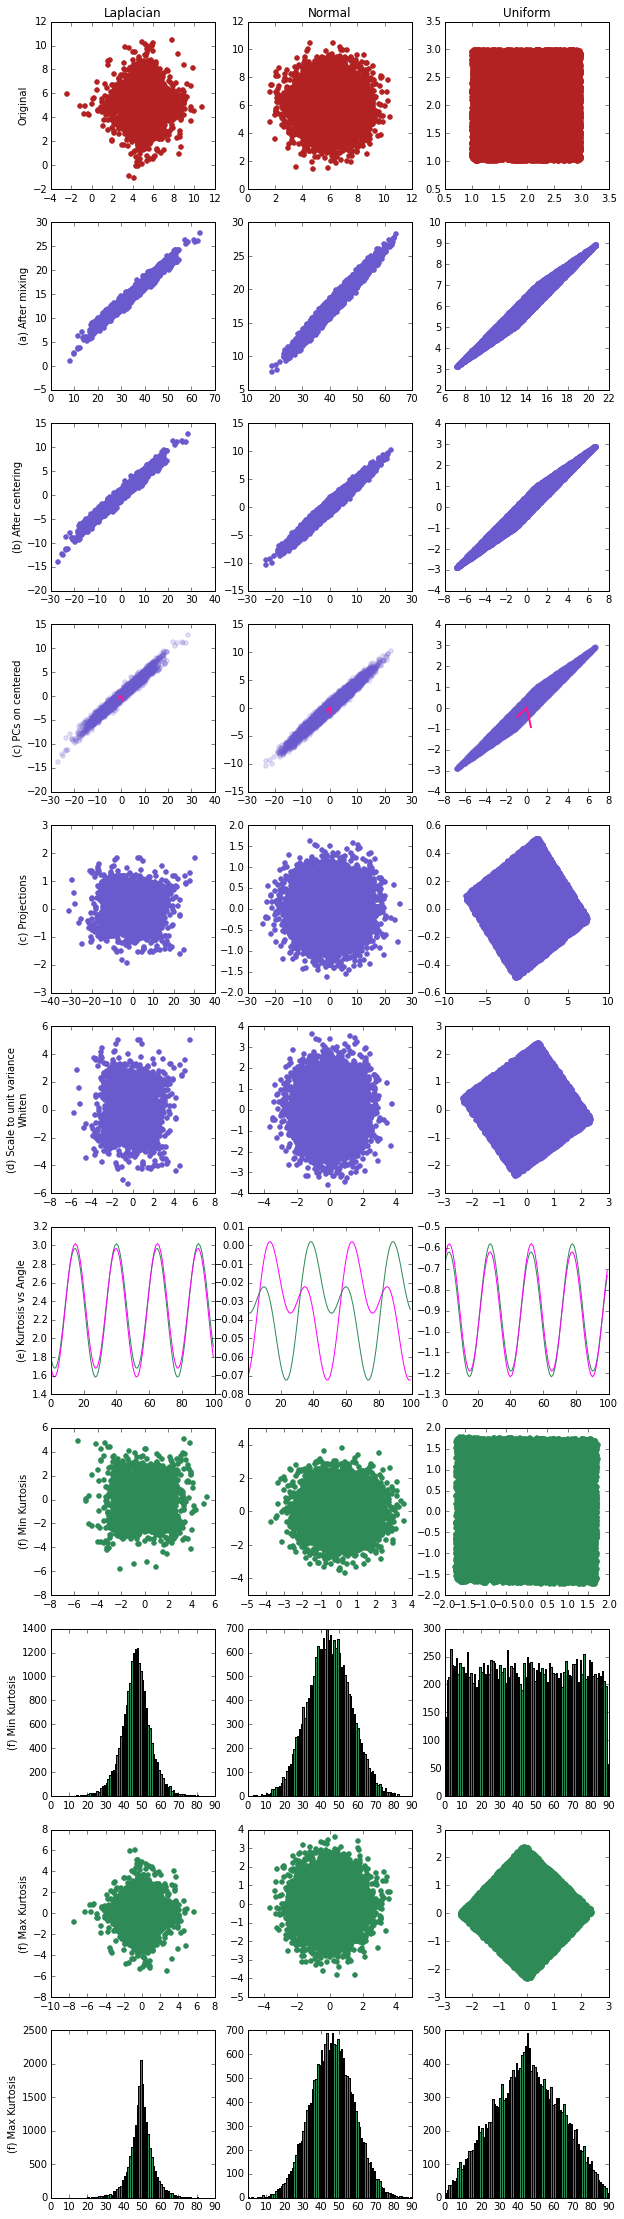

In [65]:
bins = 90
f, axarr = plt.subplots(11, 3)
f.set_size_inches(10, 39, forward=False)

r = 0
axarr[r, 0].set_title("Laplacian")
axarr[r, 1].set_title("Normal")
axarr[r, 2].set_title("Uniform")

axarr[r, 0].set_ylabel("Original")
axarr[r, 0].scatter(laplacian[0], laplacian[1], color="firebrick")
axarr[r, 1].scatter(normal[0], normal[1], color="firebrick")
axarr[r, 2].scatter(uniform[0], uniform[1], color="firebrick")

r = r+1
axarr[r, 0].set_ylabel("(a) After mixing")
axarr[r, 0].scatter(xl[0], xl[1], color="slateblue")
axarr[r, 1].scatter(xn[0], xn[1], color="slateblue")
axarr[r, 2].scatter(xu[0], xu[1], color="slateblue")

r = r+1
axarr[r, 0].set_ylabel("(b) After centering")
axarr[r, 0].scatter(xlc.T[0], xlc.T[1], color="slateblue")
axarr[r, 1].scatter(xnc.T[0], xnc.T[1], color="slateblue")
axarr[r, 2].scatter(xuc.T[0], xuc.T[1], color="slateblue")

r = r+1
axarr[r, 0].set_ylabel("(c) PCs on centered")
axarr[r, 0].scatter(xlc.T[0], xlc.T[1], color="slateblue", alpha=.2)
axarr[r, 0].plot([0, Ul[0,0]], [0,Ul[0,1]], color="deeppink", linewidth=2)
axarr[r, 0].plot([0, Ul[1,0]], [0,Ul[1,1]], color="deeppink", linewidth=2)
axarr[r, 1].scatter(xnc.T[0], xnc.T[1], color="slateblue", alpha=.2)
axarr[r, 1].plot([0, Ul[0,0]], [0,Ul[0,1]], color="deeppink", linewidth=2)
axarr[r, 1].plot([0, Ul[1,0]], [0,Ul[1,1]], color="deeppink", linewidth=2)
axarr[r, 2].scatter(xuc.T[0], xuc.T[1], color="slateblue", alpha=.2)
axarr[r, 2].plot([0, Ul[0,0]], [0,Ul[0,1]], color="deeppink", linewidth=2)
axarr[r, 2].plot([0, Ul[1,0]], [0,Ul[1,1]], color="deeppink", linewidth=2)

r = r+1
axarr[r, 0].set_ylabel("(c) Projections")
axarr[r, 0].scatter(xlp.T[0], xlp.T[1], color="slateblue")
axarr[r, 1].scatter(xnp.T[0], xnp.T[1], color="slateblue")
axarr[r, 2].scatter(xup.T[0], xup.T[1], color="slateblue")

r = r+1
axarr[r, 0].set_ylabel("(d) Scale to unit variance\nWhiten")
axarr[r, 0].scatter(xlpuv.T[0], xlpuv.T[1], color="slateblue")
axarr[r, 1].scatter(xnpuv.T[0], xnpuv.T[1], color="slateblue")
axarr[r, 2].scatter(xupuv.T[0], xupuv.T[1], color="slateblue")

r = r+1
axarr[r, 0].set_ylabel("(e) Kurtosis vs Angle")
axarr[r, 0].plot(range(len(kurtls[:,0])), kurtls[:,0], color="seagreen")
axarr[r, 0].plot(range(len(kurtls[:,1])), kurtls[:,1], color="magenta")
axarr[r, 1].plot(range(len(kurtns[:,0])), kurtns[:,0], color="seagreen")
axarr[r, 1].plot(range(len(kurtns[:,1])), kurtns[:,1], color="magenta")
axarr[r, 2].plot(range(len(kurtus[:,0])), kurtus[:,0], color="seagreen")
axarr[r, 2].plot(range(len(kurtus[:,1])), kurtus[:,1], color="magenta")

r = r+1
axarr[r, 0].set_ylabel("(f) Min Kurtosis")
axarr[r, 0].scatter(np.dot(rs[kurtlminidx], xlpuv.T)[0], np.dot(rs[kurtlminidx], xlpuv.T)[1], color="seagreen")
axarr[r, 1].scatter(np.dot(rs[kurtnminidx], xnpuv.T)[0], np.dot(rs[kurtnminidx], xnpuv.T)[1], color="seagreen")
axarr[r, 2].scatter(np.dot(rs[kurtuminidx], xupuv.T)[0], np.dot(rs[kurtuminidx], xupuv.T)[1], color="seagreen")

r = r+1
axarr[r, 0].set_ylabel("(f) Min Kurtosis")
histodata = np.histogram(np.dot(rs[kurtlminidx], xlpuv.T), bins)
axarr[r, 0].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")
histodata = np.histogram(np.dot(rs[kurtnminidx], xnpuv.T), bins)
axarr[r, 1].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")
histodata = np.histogram(np.dot(rs[kurtuminidx], xupuv.T), bins)
axarr[r, 2].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")

r = r+1
axarr[r, 0].set_ylabel("(f) Max Kurtosis")
axarr[r, 0].scatter(np.dot(rs[kurtlmaxidx], xlpuv.T)[0], np.dot(rs[kurtlmaxidx], xlpuv.T)[1], color="seagreen")
axarr[r, 1].scatter(np.dot(rs[kurtnmaxidx], xnpuv.T)[0], np.dot(rs[kurtnmaxidx], xnpuv.T)[1], color="seagreen")
axarr[r, 2].scatter(np.dot(rs[kurtumaxidx], xupuv.T)[0], np.dot(rs[kurtumaxidx], xupuv.T)[1], color="seagreen")

r = r+1
axarr[r, 0].set_ylabel("(f) Max Kurtosis")
histodata = np.histogram(np.dot(rs[kurtlmaxidx], xlpuv.T), bins)
axarr[r, 0].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")
histodata = np.histogram(np.dot(rs[kurtnmaxidx], xnpuv.T), bins)
axarr[r, 1].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")
histodata = np.histogram(np.dot(rs[kurtumaxidx], xupuv.T), bins)
axarr[r, 2].bar(np.arange(len(histodata[0])), histodata[0], color="seagreen")

plt.show()

